In [1]:
!pip install bnpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 5.9 MB/s eta 0:00:0000:0100:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-3.0.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
  Using cached joblib-0.14.1-py2.py3-none-any.whl.metadata (4.5 kB)
  Using cached memory_profiler-0.61.0-py3-none-any.whl.metadata (20 kB)
  Using cached munkres-1.0.12-py2.py3-none-any.whl.metadata (9.6 kB)
  Using cached sphinx_gallery-0.15.0-py3-none-any.whl.metadata (6.2 kB)
INFO: pip is looking at multiple versions of scikit-learn to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of scikit-learn to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency reso

In [1]:
import bayesian_hmm
import numpy as np
import matplotlib.pyplot as plt
# create emission sequences
# base_sequence = list(range(5)) + list(range(5, 0, -1))
# sequences = [base_sequence * 20 for _ in range(50)]

# plt.plot(sequences[0])

/home/davcic/.conda/envs/CPJax/lib/python3.10/site-packages/bayesian_hmm/__init__.py:13: UserWarning: bayesian_hmm is in beta testing and future versions may behave differently
  warnings.warn(


In [2]:
import os

args = 8
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import sys
sys.path.append('/home/davcic/CP_Testing')

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult
from fullgp import FullLatentGPModelhyper_mult

key = jrnd.PRNGKey(12345)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Selected GPU 8


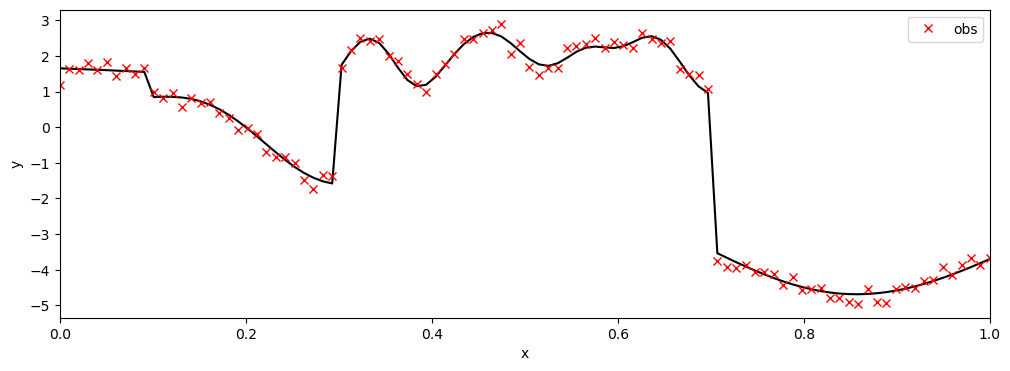

In [3]:
'''DATASET 1'''
key = jrnd.PRNGKey(1235)

f_true = jnp.load("f_true.npy")
y = jnp.load("y.npy")

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-5*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

# f_true = jnp.dot(L, z) + jnp.ones_like(z)
# key, obs_key = jrnd.split(key)
# y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [7]:
base_sequence = list(range(5)) + list(range(5, 0, -1))
sequences = [base_sequence * 20 for _ in range(50)]
print(np.array(sequences).shape)

(50, 200)


In [6]:
# new_arr = np.expand_dims(np.asarray(y), axis=1)
sequences2 = [np.asarray(y).tolist() for _ in range(3)]

In [7]:
# new_arr = np.expand_dims(np.asarray(y), axis=1)
# initialise object with overestimate of true number of latent states
hmm = bayesian_hmm.HDPHMM(sequences2, sticky=False)
hmm.initialise(k=10)

results = hmm.mcmc(n=1000, burn_in=100, ncores=3, save_every=10, verbose=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/davcic/.conda/envs/CPJax/lib/python3.10/site-packages/scipy/stats/_multivariate.py:1633: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
/home/davcic/.conda/envs/CPJax/lib/python3.10/site-packages/bayesian_hmm/hdphmm.py:1131: RuntimeWarning: invalid value encountered in scalar subtract
  p_accept = min(1, np.exp(likelihood_proposed - likelihood_curr))
 34%|███▍      | 339/1000 [01:30<02:56,  3.75it/s]


ValueError: Each entry in 'x' must be greater than zero if its alpha is less than one.

In [21]:
# print final probability estimates (expect 10 latent states)
hmm.print_probabilities()




╔═════╦═══════╗
║ S_i ║ Y_0   ║
╠═════╬═══════╣
║ f   ║ 0.034 ║
║ c   ║ 0.0   ║
║ a   ║ 0.001 ║
║ d   ║ 0.046 ║
║ e   ║ 0.009 ║
║ h   ║ 0.84  ║
║ b   ║ 0.024 ║
║ g   ║ 0.0   ║
║ i   ║ 0.043 ║
║ j   ║ 0.002 ║
╚═════╩═══════╝


╔Emission probabilities══════════╦═══════════════════╦═══════════════════╦════════════════════╦════════════════════╦════════════════════╦════════════════════╦════════════════════╦════════════════════╦═══════════════════╦════════════════════╦════════════════════╦═══════════════════╦═══════════════════╦════════════════════╦═════════════════════╦════════════════════╦════════════════════╦═════════════════╦════════════════════╦════════════════════╦════════════════════╦════════════════════╦═════════════════════╦════════════════════╦══════════════════════╦════════════════════╦═══════════════════╦═══════════════════╦══════════════════╦═════════════════════╦════════════════════╦══════════════════╦═══════════════════╦═════════════════════╦═══════════════════╦═════════════

In [22]:
results['state_count']

[10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10]

In [25]:
plt.style.use('ggplot')

# plot the number of states as a histogram
sns.countplot(results['state_count'])
plt.title('Number of latent states')
plt.xlabel('Number of latent states')
plt.ylabel('Number of iterations')
plt.show()

SystemError: <built-in function isinstance> returned a result with an exception set

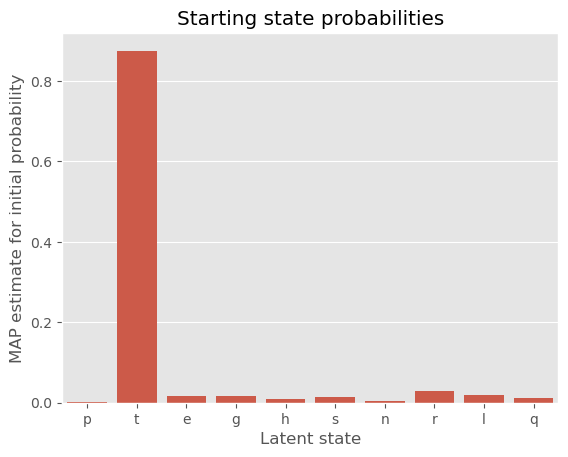

In [9]:
# plot the starting probabilities of the sampled MAP estimate
map_index = results['chain_loglikelihood'].index(min(results['chain_loglikelihood']))
parameters_map = results['parameters'][map_index]
sns.barplot(
    x=list(parameters_map['p_initial'].keys()), 
    y=list(parameters_map['p_initial'].values())
)
plt.title('Starting state probabilities')
plt.xlabel('Latent state')
plt.ylabel('MAP estimate for initial probability')
plt.show()

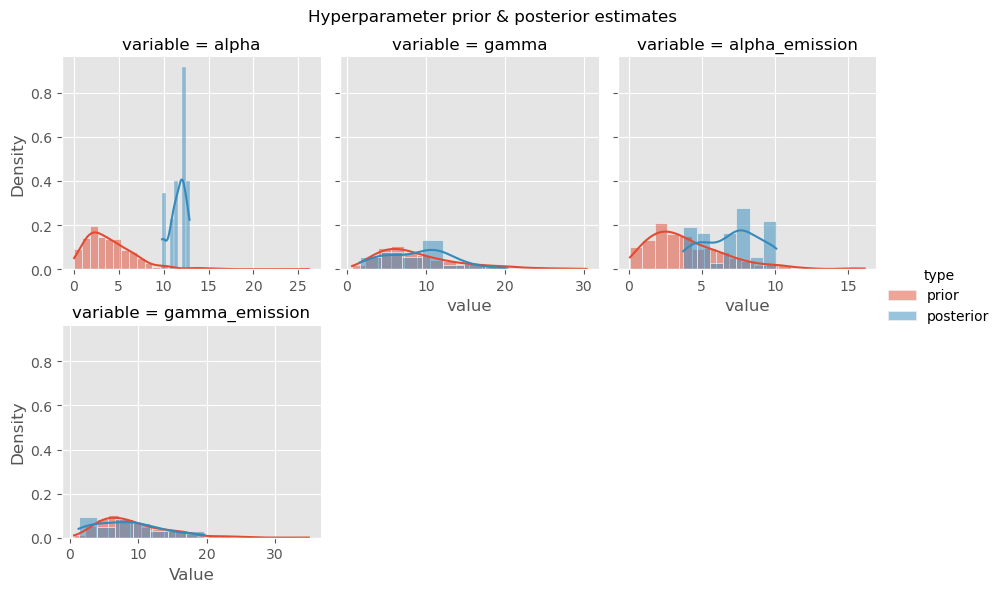

In [25]:
# convert list of hyperparameters into a DataFrame
hyperparam_posterior_df = (
    pd.DataFrame(results['hyperparameters'])
    .reset_index()
    .melt(id_vars=['index'])
    .rename(columns={'index': 'iteration'})
)
hyperparam_prior_df = pd.concat(
    pd.DataFrame(
        {'iteration': range(500), 'variable': k, 'value': [v() for _ in range(500)]}
    )
    for k, v in hmm.priors.items()
)
hyperparam_df = pd.concat(
    (hyperparam_prior_df, hyperparam_posterior_df), 
    keys=['prior', 'posterior'], 
    names=('type','index')
)
hyperparam_df.reset_index(inplace=True)

# advanced: plot sampled prior & sampled posterior together
g = sns.FacetGrid(
    hyperparam_df[hyperparam_df['variable'] != 'kappa'],
    col='variable', 
    col_wrap=3, 
    sharex=False,
    hue='type'
)
g.map(sns.histplot, 'value', kde=True, stat="density")
# g.map(sns.distplot, 'value')
g.add_legend()
g.figure.suptitle('Hyperparameter prior & posterior estimates')
plt.subplots_adjust(top=0.9)
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [28]:
parameters_map.keys()

dict_keys(['p_initial', 'p_emission', 'p_transition'])

In [30]:
parameters_map['p_emission']

{0: 0.0005439300048395374,
 1: 0.00043482473650340297,
 2: 8.186009816001438e-05,
 3: 0.9958275461127281,
 4: 0.002961814609778673,
 5: 0.00015002443799031246}